# Airbnb

# Business Understanding

[Airbnb](https://www.airbnb.com) is a hospitality firm that "<i>uniquely leverages technology to economically empower millions of people around the world to unlock and monetize their spaces, passions and talents to become hospitality entrepreneurs</i>". Our scope in this notebook is focused on the landlord's perspective, how these users can leverage Airbnb to maximize their profit. 

<br>
We will aim to answer the following questions using the data:

- How do prices vary by date?
- How long do rentals stay empty?
- How do we increase listing price?

This notebook is organized using the [CRISP-DM](https://www.datasciencecentral.com/profiles/blogs/crisp-dm-a-standard-methodology-to-ensure-a-good-outcome) methology:

- Business Understanding
- Data Understanding
- Prepare Data
- Data Modeling
- Evaluate the Results

# Imports

In [1]:
#list all imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline

#  Data Understanding

Obtaining the data is a piece of cake. Click the link below and expect ~75MB of download:

https://www.kaggle.com/airbnb/boston

## Calendar Listings

### Load Data

In [2]:
#load the data
calendar = pd.read_csv('boston/calendar.csv')

In [3]:
#first look
calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [4]:
#Describer data
calendar.describe()

,listing_id
count,1.308890e+06
mean,8.442118e+06
std,4.500149e+06
min,3.353000e+03
25%,4.679319e+06
50%,8.578710e+06
75%,1.279603e+07
max,1.493346e+07


In [5]:
#count unique value
calendar.nunique()

listing_id    3585
date           365
available        2
price         1246
dtype: int64

In [6]:
#get shape 
calendar.shape

(1308890, 4)

In [7]:
#get proportion of missing values per feature
calendar_nan_count= calendar.isna().mean()
print(calendar_nan_count)

listing_id    0.000000
date          0.000000
available     0.000000
price         0.508716
dtype: float64


In [8]:
calendar.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [9]:
#unique entries in available column
calendar['available'].unique()

array(['f', 't'], dtype=object)

In [10]:
#see characteristics of of dataframe with missing values dropped
calendar.dropna().nunique()

listing_id    2906
date           365
available        1
price         1246
dtype: int64

In [11]:
#note that available has only one type
calendar.dropna()['available'].unique()

array(['t'], dtype=object)

### Calendar Exploration Summary

We discovered that the data types in the calendar listings are listed as objects (strings). When attempting to describe the data to obtain meaningful statistics, the non numeric data is ignored by the method. In addition, we saw that for a listings to have a price it must be listed as available. We now understand that we must first get the data types in order.

## Listings

In [12]:
#load listings
listings= pd.read_csv("boston/listings.csv")

In [13]:
listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.3


In [14]:
# get shape
listings.shape

(3585, 95)

In [15]:
#so many features we have to explicitly print them out and print type

for col, d in zip (listings.columns, listings.dtypes):
    print((col)+ " :    "+ str(d))

id :    int64
listing_url :    object
scrape_id :    int64
last_scraped :    object
name :    object
summary :    object
space :    object
description :    object
experiences_offered :    object
neighborhood_overview :    object
notes :    object
transit :    object
access :    object
interaction :    object
house_rules :    object
thumbnail_url :    object
medium_url :    object
picture_url :    object
xl_picture_url :    object
host_id :    int64
host_url :    object
host_name :    object
host_since :    object
host_location :    object
host_about :    object
host_response_time :    object
host_response_rate :    object
host_acceptance_rate :    object
host_is_superhost :    object
host_thumbnail_url :    object
host_picture_url :    object
host_neighbourhood :    object
host_listings_count :    int64
host_total_listings_count :    int64
host_verifications :    object
host_has_profile_pic :    object
host_identity_verified :    object
street :    object
neighbourhood :    object
neig

In [16]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,calculated_host_listings_count,reviews_per_month
count,3.585000e+03,3.585000e+03,3.585000e+03,3585.000000,3585.000000,0.0,3585.000000,3585.000000,3585.000000,3571.000000,...,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,0.0,0.0,3585.000000,2829.000000
mean,8.440875e+06,2.016091e+13,2.492311e+07,58.902371,58.902371,NaN,42.340032,-71.084818,3.041283,1.221647,...,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,NaN,NaN,12.733891,1.970908
std,4.500787e+06,8.516813e-01,2.292781e+07,171.119663,171.119663,NaN,0.024403,0.031565,1.778929,0.501487,...,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116,NaN,NaN,29.415076,2.120561
min,3.353000e+03,2.016091e+13,4.240000e+03,0.000000,0.000000,NaN,42.235942,-71.171789,1.000000,0.000000,...,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,NaN,NaN,1.000000,0.010000
25%,4.679319e+06,2.016091e+13,6.103425e+06,1.000000,1.000000,NaN,42.329995,-71.105083,2.000000,1.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,NaN,1.000000,0.480000
50%,8.577620e+06,2.016091e+13,1.928100e+07,2.000000,2.000000,NaN,42.345201,-71.078429,2.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,NaN,2.000000,1.170000
75%,1.278953e+07,2.016091e+13,3.622147e+07,7.000000,7.000000,NaN,42.354685,-71.062155,4.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,6.000000,2.720000
max,1.493346e+07,2.016091e+13,9.385411e+07,749.000000,749.000000,NaN,42.389982,-71.000100,16.000000,6.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,136.000000,19.150000


### Listings Exploration Summary

We have an overwhelming amount of data and a lot of it is in text form. For this data we will have to do a lot digging into the features to figure out which ones to keep. We do not want to spend time cleaning the data just to realize we could have dropped the features.

# Data Preparation

## Calendar

In [17]:
#fix the date column to be datetime
calendar['date']=pd.to_datetime(calendar['date'], format="%Y-%m-%d")

In [18]:
#replace t with 1 and f with 0
calendar['available']=calendar.available.replace({'t':1, 'f':0})

In [19]:
#remove the dollar signs and commas with successive strip
calendar.price=calendar['price'].apply(lambda x: x.replace("$","").replace(",","")
                                if pd.isna(x)==False else np.nan)
#make numeric
calendar.price= pd.to_numeric(calendar.price)

In [20]:
#with prices fixed we can see statistics
calendar.describe()

,listing_id,available,price
count,1.308890e+06,1.308890e+06,643037.000000
mean,8.442118e+06,4.912842e-01,198.438909
std,4.500149e+06,4.999242e-01,180.142913
min,3.353000e+03,0.000000e+00,11.000000
25%,4.679319e+06,0.000000e+00,85.000000
50%,8.578710e+06,0.000000e+00,150.000000
75%,1.279603e+07,1.000000e+00,255.000000
max,1.493346e+07,1.000000e+00,7163.000000


In [21]:
#drop all prices below $50 and keep the nans
calendar=calendar[(calendar['price']>= 50) | (calendar.price.isnull()== True)]

In [22]:
#get list of unique listings
unique_id= calendar.listing_id.unique()

In [23]:
#store entirely nan listing ids in array
empty_id=[]

#check if for one id all entires are nan
for name in unique_id:
    temp_df=calendar[calendar['listing_id']==name]['price']
    if pd.isna(temp_df).sum()/temp_df.shape[0]==1:
        empty_id.append(name)

In [24]:
#get calendar with known values for at least one id
calendar_full= calendar.copy()
calendar_full= calendar_full.loc[~calendar_full.listing_id.isin(empty_id), :]

In [25]:
#see how much data is left
calendar_full.shape[0]/calendar.shape[0]

0.7978993651153784

[stack overflow post for step below](https://stackoverflow.com/questions/50991766/how-does-pandas-replace-nan-values-with-mean-value-using-groupby) on how to replace NaN values with mean value using groupby.

In [26]:
#for a missing value, replace with the average price for that id
calendar_nan = calendar_full.copy()

#get the average associated with each id
nan_avg = calendar_nan.groupby('listing_id')['price'].transform('mean')
calendar_nan['price'].fillna(nan_avg, inplace=True)

#round to nearest digit to look clean
calendar_nan.price= calendar_nan.price.round()

In [27]:
#extract day of week, day of year, and month
day_of_week, day_of_year, week_of_year,month = zip(*[(d.dayofweek, d.dayofyear, d.weekofyear,d.month) for d in calendar_nan['date']])

#create a copy of the previous dataframe
calendar_clean= calendar_nan.copy()

#assign new columns to dataframe
calendar_clean = calendar_nan.assign(day_of_week=day_of_week,
                                     day_of_year=day_of_year, week_of_year=week_of_year,month=month)

In [28]:
#reset the index
calendar_clean=calendar_clean.reset_index()

In [29]:
#look at random sample
calendar_clean.sample(n=10)

,index,listing_id,date,available,price,day_of_week,day_of_year,week_of_year,month
367348,471984,13614982,2017-07-02,0,228.0,6,183,26,7
585929,734987,13993185,2017-06-30,0,200.0,4,181,26,6
858714,1090216,3394437,2016-10-14,0,300.0,4,288,41,10
625123,783671,14897997,2017-08-20,0,309.0,6,232,33,8
785984,994580,3974503,2016-10-20,0,65.0,3,294,42,10
829493,1053638,10610205,2016-12-31,1,76.0,5,366,52,12
279948,362684,12890156,2017-07-12,1,149.0,2,193,28,7
46212,62769,4567815,2016-09-16,0,120.0,4,260,37,9
354225,456306,56927,2017-04-14,1,289.0,4,104,15,4
129338,170975,8184662,2017-04-03,0,319.0,0,93,14,4


## Listings

In [30]:
#drop columns we deem uncessary from their name
listings_drop_cols= ['listing_url','scrape_id','last_scraped', 'has_availability',
                     'experiences_offered',
                     'host_name','calendar_last_scraped','requires_license',
                     'calendar_last_scraped']

#drop columns in list
listings =listings.drop(columns=listings_drop_cols)

#drop columns with url in name
listings = listings[listings.columns.drop(list(listings.filter(regex='url')))]

In [31]:
#get nan columns
listings_nan_cols = listings.columns[listings.isna().any()].tolist()
listings_nan_cols

['summary',
 'space',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_neighbourhood',
 'neighbourhood',
 'neighbourhood_group_cleansed',
 'city',
 'zipcode',
 'market',
 'property_type',
 'bathrooms',
 'bedrooms',
 'beds',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'cleaning_fee',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'jurisdiction_names',
 'reviews_per_month']

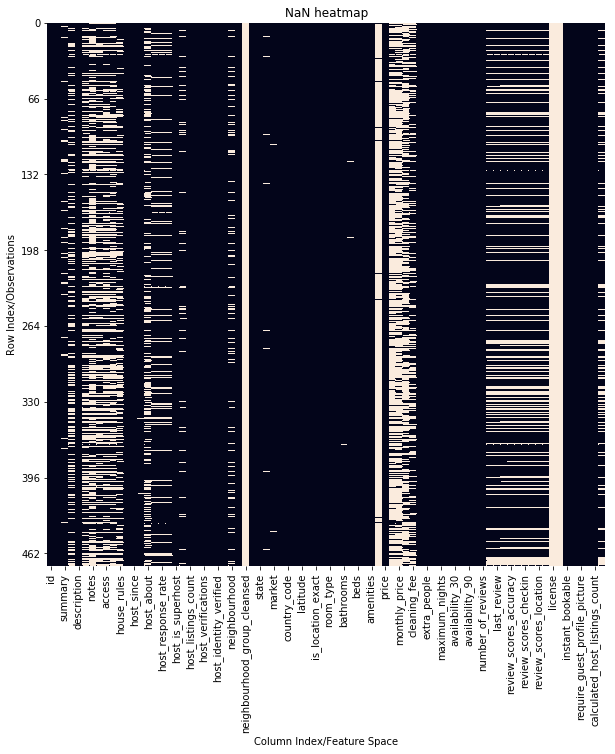

In [32]:
#nan as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(listings.isnull(), cbar=False)
plt.title("NaN heatmap")
#plt.xticks(np.arange(0, listings.shape[1], 10))
plt.yticks(np.arange(0, listings.shape[0], 500))
plt.xlabel("Column Index/Feature Space")
plt.ylabel("Row Index/Observations")
plt.savefig("plots/nan_heat.png")

plt.show()

In [33]:
#see columns with more than 50% missing
listings_nan_cutoff = listings.columns[listings.isna().mean() >= 0.5].tolist()
listings_nan_cutoff

['notes',
 'neighbourhood_group_cleansed',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'security_deposit',
 'license',
 'jurisdiction_names']

In [34]:
#get a copy of df
listings_drop = listings.copy()

#keep notes
listings_nan_cutoff.remove('notes')

#drop columns
listings_drop= listings_drop.drop(columns=listings_nan_cutoff)

#drop columns that have no summary
listings_drop= listings_drop[pd.notnull(listings_drop['summary'])]

In [35]:
has_notes = []
has_interaction= []
has_access = []

for i,j, k in zip (listings_drop.notes, listings_drop.interaction, listings_drop.access):
    if pd.isna(i):
        has_notes.append(0)
    else:
        has_notes.append(1)
    if pd.isna(j):
        has_interaction.append(0)
    else:
        has_interaction.append(1)
    if pd.isna(k):
        has_access.append(0)
    else:
        has_access.append(1)
        

#add the new columns
listings_drop['interaction']= has_interaction
listings_drop['access']= has_access
listings_drop['notes']= has_notes

In [36]:
#remove the dollar signs and commas with successive strip
listings_drop.price=listings_drop['price'].apply(lambda x: x.replace("$","").replace(",","")
                                if pd.isna(x)==False else np.nan)
#make numeric
listings_drop.price= pd.to_numeric(listings_drop.price)

In [37]:
#make summary lowercase
listings_drop.summary= listings_drop.summary.str.lower()

In [38]:
#list out columns
listings_drop.columns

Index(['id', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'host_id', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'price', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availabili

In [39]:
#make copy of dataframe
listings_small= listings_drop.copy()

#take susbet of columns
listings_small=listings_small[['price','summary', 'interaction', 'notes', 'access',
                              'host_acceptance_rate', 'host_response_rate',
                               'host_response_time', 'longitude', 'latitude', 'room_type',
                              'accommodates', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews',
                              ]]
listings_small.head()

,price,summary,interaction,notes,access,host_acceptance_rate,host_response_rate,host_response_time,longitude,latitude,room_type,accommodates,bathrooms,bedrooms,beds,number_of_reviews
0,250.0,"cozy, sunny, family home. master bedroom high...",0,0,1,NaN,NaN,NaN,-71.133068,42.282619,Entire home/apt,4,1.5,2.0,3.0,0
1,65.0,charming and quiet room in a second floor 1910...,1,1,1,100%,100%,within an hour,-71.134374,42.286241,Private room,2,1.0,1.0,1.0,36
2,65.0,"come stay with a friendly, middle-aged guy in ...",1,1,1,88%,100%,within a few hours,-71.135765,42.292438,Private room,2,1.0,1.0,1.0,41
3,75.0,come experience the comforts of home away from...,1,1,1,50%,100%,within a few hours,-71.121021,42.281106,Private room,4,1.0,1.0,2.0,1
4,79.0,"my comfy, clean and relaxing home is one block...",1,1,1,100%,100%,within an hour,-71.136258,42.284512,Private room,2,1.5,1.0,2.0,29


In [40]:
#see types
listings_small.dtypes

price                   float64
summary                  object
interaction               int64
notes                     int64
access                    int64
host_acceptance_rate     object
host_response_rate       object
host_response_time       object
longitude               float64
latitude                float64
room_type                object
accommodates              int64
bathrooms               float64
bedrooms                float64
beds                    float64
number_of_reviews         int64
dtype: object

In [41]:
#see missing values
listings_small.isna().mean()

price                   0.000000
summary                 0.000000
interaction             0.000000
notes                   0.000000
access                  0.000000
host_acceptance_rate    0.135677
host_response_rate      0.135677
host_response_time      0.135677
longitude               0.000000
latitude                0.000000
room_type               0.000000
accommodates            0.000000
bathrooms               0.001453
bedrooms                0.000581
beds                    0.002324
number_of_reviews       0.000000
dtype: float64

In [42]:
#make acceptance rate numeric
listings_small.host_acceptance_rate=listings_small['host_acceptance_rate'].apply(lambda x: x.replace("%","")
                                                                  if pd.isna(x)==False else np.nan)
#make numeric
listings_small.host_acceptance_rate= pd.to_numeric(listings_small.host_acceptance_rate)

#repeat for response rate 
listings_small.host_response_rate=listings_small['host_response_rate'].apply(lambda x: x.replace("%","")
                                                                  if pd.isna(x)==False else np.nan)
#make numeric
listings_small.host_response_rate= pd.to_numeric(listings_small.host_response_rate)

#replace nans in rates with 0
values = {'host_acceptance_rate': 0, 'host_response_rate': 0}

listings_small.fillna(value=values, inplace=True)

In [43]:
#see unique values in host response time
listings_small.host_response_time.unique()

array([nan, 'within an hour', 'within a few hours', 'within a day',
       'a few days or more'], dtype=object)

In [44]:
#unique bedrooms
listings_small.bathrooms.unique()

array([1.5, 1. , 2. , 0. , 2.5, 3.5, 3. , nan, 0.5, 4.5, 4. , 5. , 6. ])

In [45]:
#unique bedrooms
listings_small.bedrooms.unique()

array([ 2.,  1.,  0.,  3.,  4.,  5., nan])

In [46]:
#unique bedrooms
listings_small.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [47]:
#dataframe that will include encoded dummy variables
listings_dum= listings_small.copy()

#get dummies and concatenate
listings_dum= pd.concat([listings_dum, pd.get_dummies(listings_small.host_response_time,
                                                      prefix='resp_time',
                                                      dummy_na=True)], axis=1)

listings_dum= pd.concat([listings_dum, pd.get_dummies(listings_small.bathrooms,
                                                      prefix='bathrooms',
                                                      dummy_na=True)], axis=1)

listings_dum= pd.concat([listings_dum, pd.get_dummies(listings_small.bedrooms,
                                                      prefix='bedrooms',
                                                      dummy_na=True)], axis=1)

listings_dum= pd.concat([listings_dum, pd.get_dummies(listings_small.room_type,
                                                      prefix='room_type',
                                                      dummy_na=True)], axis=1)


listings_dum= pd.concat([listings_dum, pd.get_dummies(listings_small.beds,
                                                      prefix='beds',
                                                      dummy_na=True)], axis=1)

listings_dum= listings_dum.drop(columns=['host_response_time', 'bathrooms',
                                         'bedrooms', 'room_type', 'beds'])

listings_dum.head()

,price,summary,interaction,notes,access,host_acceptance_rate,host_response_rate,longitude,latitude,accommodates,...,beds_2.0,beds_3.0,beds_4.0,beds_5.0,beds_6.0,beds_7.0,beds_8.0,beds_9.0,beds_16.0,beds_nan
0,250.0,"cozy, sunny, family home. master bedroom high...",0,0,1,0.0,0.0,-71.133068,42.282619,4,...,0,1,0,0,0,0,0,0,0,0
1,65.0,charming and quiet room in a second floor 1910...,1,1,1,100.0,100.0,-71.134374,42.286241,2,...,0,0,0,0,0,0,0,0,0,0
2,65.0,"come stay with a friendly, middle-aged guy in ...",1,1,1,88.0,100.0,-71.135765,42.292438,2,...,0,0,0,0,0,0,0,0,0,0
3,75.0,come experience the comforts of home away from...,1,1,1,50.0,100.0,-71.121021,42.281106,4,...,1,0,0,0,0,0,0,0,0,0
4,79.0,"my comfy, clean and relaxing home is one block...",1,1,1,100.0,100.0,-71.136258,42.284512,2,...,1,0,0,0,0,0,0,0,0,0


In [48]:
#instantiate analyzer for sentiment
analyser = SentimentIntensityAnalyzer()

#define new features
length=[]
back_bay=[]
south_end= []
traveler= []
pos=[]
neutral= []
neg= []
compound= []

#loop over words in dataframe
for word in listings_dum.summary:
    
    #append length
    length.append(len(word))
    
    #1 if mentioned and 0 if omitted
    if 'back bay' in word:
        back_bay.append(1)
    else:
        back_bay.append(0)
    
    if 'south end' in word:
        south_end.append(1)
    else:
        south_end.append(0)
        
    if any(substring in word for substring in ['traveler', 'travelers', 'adventuter', 'adventuters']):
        traveler.append(1)
    else:
        traveler.append(0)
    
    #get the feels
    score= analyser.polarity_scores(word)
    
    #append feels
    pos.append(score['pos'])
    neutral.append(score['neu'])
    neg.append(score['neg'])
    compound.append(score['compound'])

In [49]:
#define new dataframe
df_sentiment= listings_dum.copy()

#add new columns
df_sentiment['length']= length
df_sentiment['back_bay']= back_bay
df_sentiment['south_end']= south_end
df_sentiment['traveler']= traveler
df_sentiment['pos']= pos
df_sentiment['neutral']= neutral
df_sentiment['neg']= neg
df_sentiment['compound']= compound

df_sentiment.head()

,price,summary,interaction,notes,access,host_acceptance_rate,host_response_rate,longitude,latitude,accommodates,...,beds_16.0,beds_nan,length,back_bay,south_end,traveler,pos,neutral,neg,compound
0,250.0,"cozy, sunny, family home. master bedroom high...",0,0,1,0.0,0.0,-71.133068,42.282619,4,...,0,0,249,0,0,0,0.367,0.633,0.000,0.9337
1,65.0,charming and quiet room in a second floor 1910...,1,1,1,100.0,100.0,-71.134374,42.286241,2,...,0,0,247,0,0,0,0.198,0.802,0.000,0.8555
2,65.0,"come stay with a friendly, middle-aged guy in ...",1,1,1,88.0,100.0,-71.135765,42.292438,2,...,0,0,244,0,0,0,0.184,0.816,0.000,0.8316
3,75.0,come experience the comforts of home away from...,1,1,1,50.0,100.0,-71.121021,42.281106,4,...,0,0,493,0,0,0,0.149,0.851,0.000,0.9186
4,79.0,"my comfy, clean and relaxing home is one block...",1,1,1,100.0,100.0,-71.136258,42.284512,2,...,0,0,245,0,0,0,0.230,0.713,0.057,0.8271


# How Do Prices Vary With Time?

In [50]:
#get available lisitings
calendar_all_available= calendar_clean.copy()
calendar_all_available= calendar_all_available[calendar_clean['available']==1]
#get unavailable listings
calendar_not_available= calendar_clean.copy()
calendar_not_available= calendar_not_available[calendar_clean['available']==0]

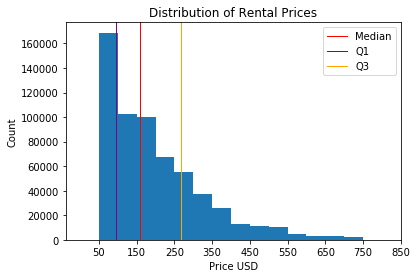

In [51]:
plt.hist(calendar_all_available['price'], bins=np.arange(0,800,50))
plt.xlabel("Price USD")
plt.ylabel("Count")

#draw median
plt.axvline(calendar_all_available['price'].median(), color = 'red', linewidth = 1)
#draw first quartile
plt.axvline(calendar_all_available['price'].quantile(0.25), color = 'purple', linewidth = 1)
#draw third quartile
plt.axvline(calendar_all_available['price'].quantile(0.75), color = 'orange', linewidth = 1)
plt.title("Distribution of Rental Prices")
plt.legend(["Median", "Q1", "Q3"])

plt.xticks(np.arange(50, 900, 100))
plt.savefig("plots/hist_price_all_available.png")


plt.show()

In [52]:
calendar_month= calendar_all_available.groupby('month', as_index=False).mean()
calendar_month.head(12)

,month,index,listing_id,available,price,day_of_week,day_of_year,week_of_year
0,1,641236.526827,7.663465e+06,1.0,189.847174,2.940268,15.997127,4.246135
1,2,638003.355735,7.617393e+06,1.0,188.244128,3.003813,45.533954,6.790020
2,3,640079.163741,7.301260e+06,1.0,189.801883,3.015197,74.728482,10.959041
3,4,642119.511069,7.275011e+06,1.0,206.263682,3.168628,105.492696,15.332010
4,5,640956.100315,7.251625e+06,1.0,202.419752,2.804967,135.985630,19.740095
5,6,641366.878250,7.264727e+06,1.0,205.218682,3.038048,166.515521,24.068210
6,7,641972.164072,7.267884e+06,1.0,211.450272,3.069203,197.021826,28.421803
7,8,639881.964560,7.262707e+06,1.0,212.268180,2.906760,228.023671,32.873844
8,9,662963.917425,7.837634e+06,1.0,244.468234,2.979993,258.245705,36.971046
9,10,668212.953642,8.234703e+06,1.0,240.886267,2.977011,290.888956,41.558849


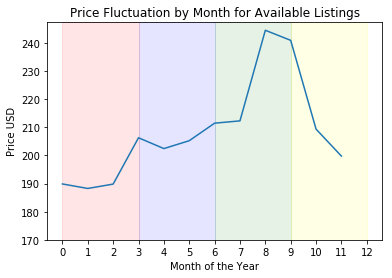

In [53]:
#plot the price
plt.plot(np.arange(0,12), calendar_month['price'])
#labels
plt.xlabel("Month of the Year")
plt.ylabel("Price USD")
plt.title("Price Fluctuation by Month for Available Listings")
#ticks
plt.xticks(np.arange(0,13,1))
plt.yticks(np.arange(170, 250, 10))
#highlights
plt.axvspan(0, 3, color='red', alpha=0.1)
plt.axvspan(3, 6, color='blue', alpha=0.1)
plt.axvspan(6, 9, color='green', alpha=0.1)
plt.axvspan(9, 12, color='yellow', alpha=0.1)



#save it
plt.savefig("plots/price_available_month")
plt.show()

In [54]:
calendar_dayofyear= calendar_all_available.groupby('day_of_year', as_index=False).mean()
calendar_dayofyear.head()

,day_of_year,index,listing_id,available,price,day_of_week,week_of_year,month
0,1,641246.942487,7.685044e+06,1.0,199.200518,6.0,52.0,1.0
1,2,641177.842924,7.678803e+06,1.0,191.156039,0.0,1.0,1.0
2,3,642348.319647,7.680584e+06,1.0,189.120582,1.0,1.0,1.0
3,4,641481.924948,7.696652e+06,1.0,189.614389,2.0,1.0,1.0
4,5,641310.992791,7.708541e+06,1.0,190.419156,3.0,1.0,1.0


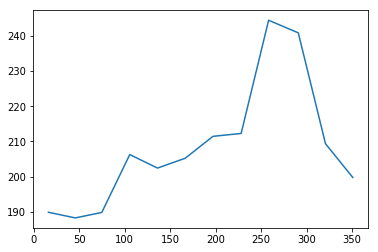

In [55]:
#plot price by day of year
plt.plot(calendar_month['day_of_year'], calendar_month['price'])

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


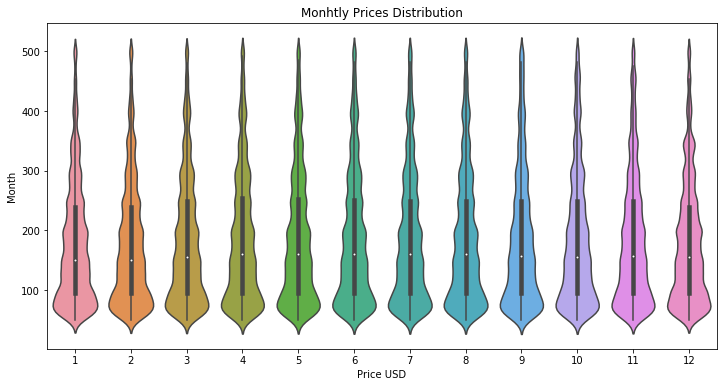

In [56]:
#see distribution of ride distance across months
plt.figure(figsize=(12, 6))
sns.violinplot(x='month', y='price',split=True,
               data=calendar_clean[calendar_clean['price']<=500])
plt.xlabel("Price USD")
plt.ylabel("Month")
plt.title("Monhtly Prices Distribution")
plt.savefig("plots/price_month_violin.png")


# How Long do Rentals Stay Empty?

In [57]:
calendar_available= calendar_clean.groupby(by=['listing_id']).mean()

In [58]:
calendar_available.head()

,index,available,price,day_of_week,day_of_year,week_of_year,month
listing_id,,,,,,,
5506,284882.0,0.942466,147.252055,2.994521,183.320548,26.526027,6.526027
6695,312257.0,0.887671,197.361644,2.994521,183.320548,26.526027,6.526027
6976,912.0,0.873973,65.000000,2.994521,183.320548,26.526027,6.526027
8792,770332.0,0.679452,154.000000,2.994521,183.320548,26.526027,6.526027
9273,563742.0,0.997260,225.000000,2.994521,183.320548,26.526027,6.526027


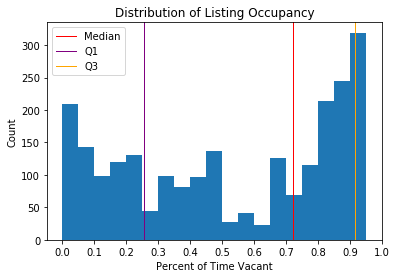

In [59]:
#draw hist
plt.hist(calendar_available['available'], bins=np.arange(0,1,0.05))
plt.xlabel("Percent of Time Vacant")
plt.ylabel("Count")

#draw median
plt.axvline(calendar_available['available'].median(), color = 'red', linewidth = 1)
#draw first quartile
plt.axvline(calendar_available['available'].quantile(0.25), color = 'purple', linewidth = 1)
#draw third quartile
plt.axvline(calendar_available['available'].quantile(0.75), color = 'orange', linewidth = 1)
plt.title("Distribution of Listing Occupancy")
#legend
plt.legend(["Median", "Q1", "Q3"])

plt.xticks(np.arange(0, 1.1, 0.1))
plt.savefig("plots/hist_available.png")


plt.show()

In [60]:
calendar_available_month= calendar_clean.groupby(by=['month'], as_index=False).mean()
calendar_available_month.head()

,month,index,listing_id,available,price,day_of_week,day_of_year,week_of_year
0,1,647063.648043,8.119147e+06,0.695860,191.179572,2.936930,16.002219,4.255422
1,2,646975.865005,8.116881e+06,0.691147,192.240940,3.001637,45.498714,6.785297
2,3,646629.285957,8.114426e+06,0.603579,198.053730,3.001825,75.000127,10.999757
3,4,647033.543980,8.119370e+06,0.579841,208.392267,3.168295,105.500626,15.333190
4,5,647052.792002,8.121157e+06,0.585621,206.524427,2.808164,135.999538,19.741625


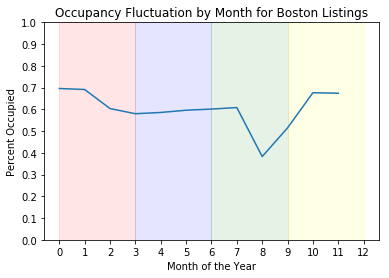

In [61]:
#plot the price
plt.plot(np.arange(0,12), calendar_available_month['available'])
#labels
plt.xlabel("Month of the Year")
plt.ylabel("Percent Occupied")
plt.title("Occupancy Fluctuation by Month for Boston Listings")
#ticks
plt.xticks(np.arange(0,13,1))
plt.yticks(np.arange(0, 1.1, 0.1))
#highlights
plt.axvspan(0, 3, color='red', alpha=0.1)
plt.axvspan(3, 6, color='blue', alpha=0.1)
plt.axvspan(6, 9, color='green', alpha=0.1)
plt.axvspan(9, 12, color='yellow', alpha=0.1)



#save it
plt.savefig("plots/vacancy_month.png")
plt.show()

In [62]:
#grou by day of year
calendar_available_day= calendar_clean.groupby(by=['day_of_year'], as_index=False).mean()


In [63]:
calendar_available_day.head()

,day_of_year,index,listing_id,available,price,day_of_week,week_of_year,month
0,1,647102.023323,8.115461e+06,0.692501,196.448870,6.0,52.0,1.0
1,2,647239.366571,8.113079e+06,0.691894,191.028694,0.0,1.0,1.0
2,3,647022.952278,8.111240e+06,0.690348,190.252243,1.0,1.0,1.0
3,4,646648.033728,8.115080e+06,0.693219,190.710800,2.0,1.0,1.0
4,5,646664.003944,8.116714e+06,0.696307,191.504482,3.0,1.0,1.0


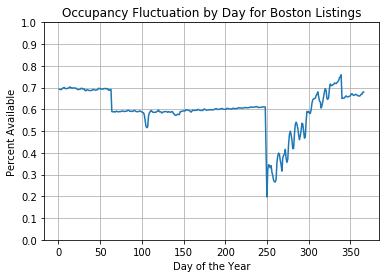

In [64]:
#plot the price
plt.plot(calendar_available_day['day_of_year'], calendar_available_day['available'])
#labels
plt.xlabel("Day of the Year")
plt.ylabel("Percent Available")
plt.title("Occupancy Fluctuation by Day for Boston Listings")
#ticks
#plt.xticks(np.arange(0,13,1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()


#save it
plt.savefig("plots/vacancy_day.png")
plt.show()

# How Do We Increase Listing Price?

In [65]:
#Combine all the reviews into one massive string
summary_text = " ".join(word for word in df_sentiment.summary)

#for clairty make everything lowercase
summary_text= summary_text.upper()

#drop all mentions of boston
summary_text = summary_text.replace("BOSTON", "")

print ("There are {} words in the combination of all reviews.".format(len(summary_text)))

There are 897569 words in the combination of all reviews.


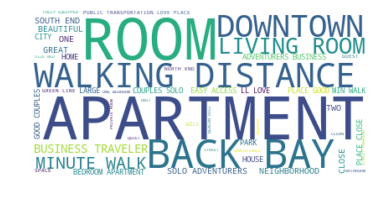

In [66]:
# Create stopword list:
stopwords = set(STOPWORDS)
#For now let's only remove the
stopwords.update(["the"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white", 
                      width= 400, height = 200, 
                      max_words=50).generate(summary_text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

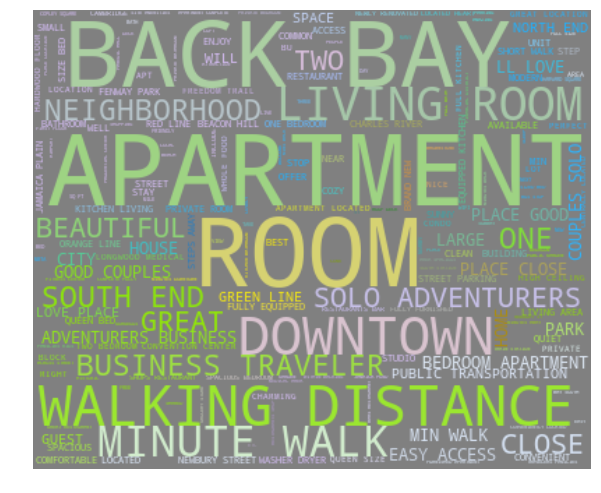

In [67]:
#Define mask for cloud
cloud_mask = np.array(Image.open("plots/400-boston-map-sightseeing.jpg"))

wordcloud_bos_cam = WordCloud(stopwords=stopwords, 
                           background_color="grey", 
                           mode="RGBA", max_words=200, 
                           mask=cloud_mask).generate(summary_text)

# create coloring from image
image_colors = ImageColorGenerator(cloud_mask)
plt.figure(figsize=(10,15))
plt.imshow(wordcloud_bos_cam.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.savefig("plots/boston_heat.png")


plt.show()

In [68]:
#get correlation coeff of dataset
pears = df_sentiment.corr()

In [69]:
#see correlations better than 0.2
pears_small=pears[(pears['price']>= 0.2) | (pears.price<=-0.2)]
pears_small= pears_small.round(decimals=2)
pears_small.head()

,price,interaction,notes,access,host_acceptance_rate,host_response_rate,longitude,latitude,accommodates,number_of_reviews,...,beds_16.0,beds_nan,length,back_bay,south_end,traveler,pos,neutral,neg,compound
price,1.00,-0.01,-0.00,-0.05,-0.10,-0.05,0.17,0.19,0.43,-0.09,...,0.01,-0.03,0.01,0.08,0.07,-0.07,-0.03,0.05,-0.06,-0.01
accommodates,0.43,0.10,0.07,0.03,0.01,0.08,0.09,0.06,1.00,0.01,...,0.07,-0.04,0.07,-0.01,0.00,-0.08,-0.05,0.05,-0.02,0.01
bathrooms_1.0,-0.21,-0.02,-0.04,-0.00,0.04,-0.03,0.03,0.04,-0.33,0.01,...,0.01,-0.03,-0.00,0.06,0.04,0.05,0.03,-0.04,0.05,0.01
bathrooms_2.0,0.20,-0.00,0.02,-0.03,-0.04,0.03,0.02,0.05,0.30,-0.03,...,-0.01,-0.02,-0.03,-0.06,-0.06,-0.04,-0.03,0.04,-0.05,-0.02
bedrooms_1.0,-0.35,0.00,-0.05,0.00,-0.00,-0.05,-0.09,-0.09,-0.59,0.06,...,0.01,0.03,0.00,-0.07,-0.09,0.07,0.00,-0.02,0.04,-0.02


In [70]:
pears_small.shape

(10, 59)

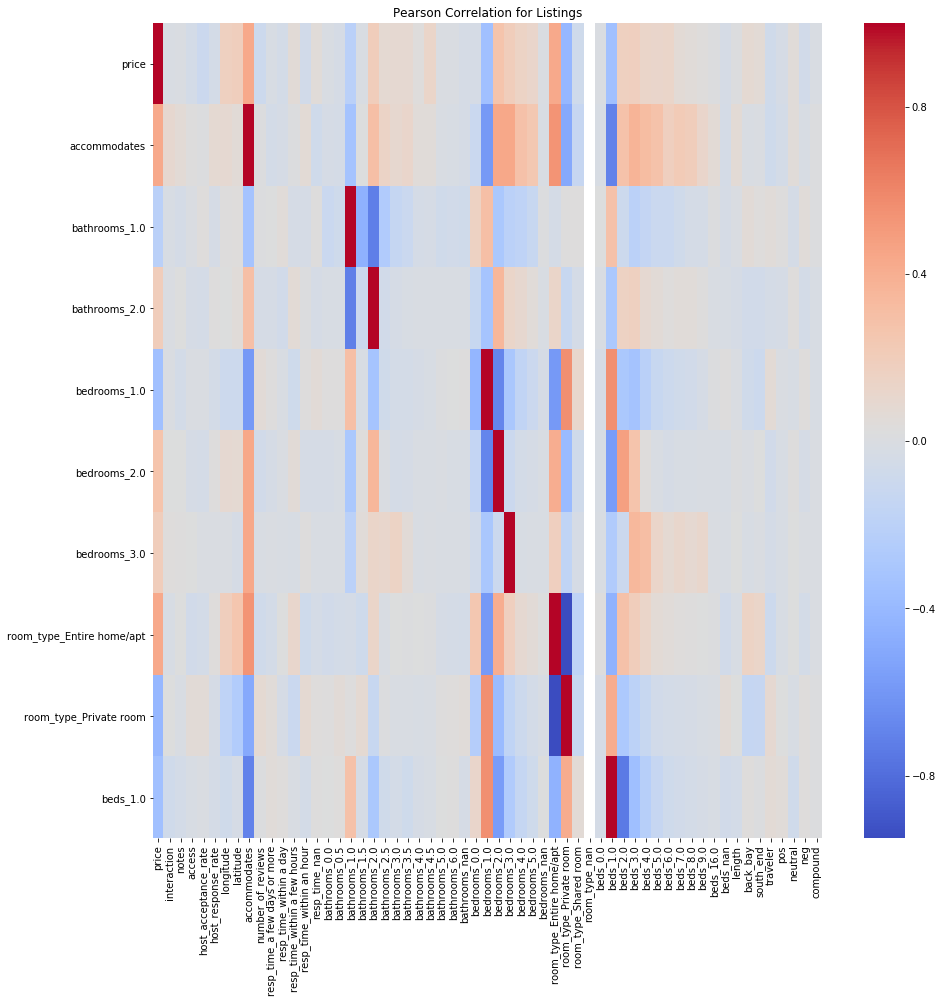

In [71]:
#plot heatmap
plt.figure(figsize=(15,15))
sns.heatmap(pears_small,
            cmap='coolwarm',
            annot=False,
           fmt='.2g');
plt.title("Pearson Correlation for Listings")
plt.savefig("plots/pearson_heat_summary.png")

In [72]:
#take text related features
df_sentiment_summary= df_sentiment[['price','length', 'back_bay', 'south_end',
                                   'traveler', 'pos', 'neg', 'compound']]

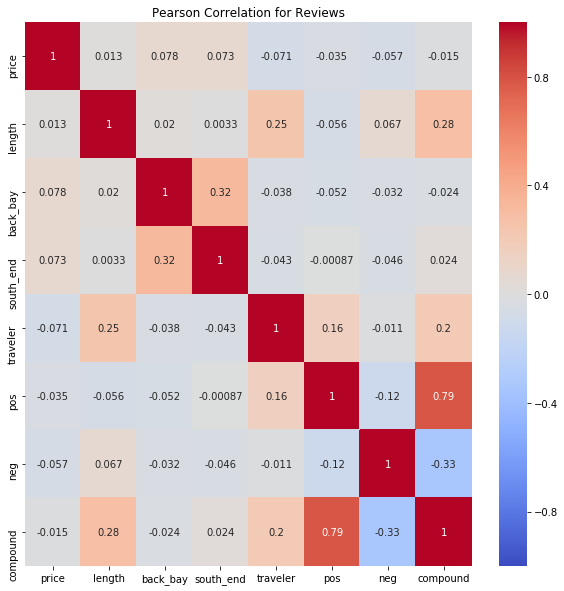

In [73]:
#pears correlation for smalelr dataset
pears_sentiment = df_sentiment_summary.corr()


plt.figure(figsize=(10,10))
sns.heatmap(pears_sentiment,
            vmin=-1,
            cmap='coolwarm',
            annot=True);
plt.title("Pearson Correlation for Reviews")
plt.savefig("plots/pearson_heat_summary_sentiment.png")

# Evalute the Results

From the evaluation above we can say with near certainty that the best time to rent out porperty in Boston is during the month of September. Listing prices make a dramatic jump as more and more get booked. In addition, we can tell that the bigger the apartment fitting capacity and the more bathrooms the higher the asking price. On the other hand, what we write in the summary seems to have little effect on price.